In [2]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from CustomModels import BetaRegression, LinearLimitedRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
dateparse = lambda x: datetime.strptime(x, '%Y/%m/%d') if isinstance(x, str) else x

In [4]:
# Load the data
data = pd.read_excel('SignedPlayersDatasetVALORANT.xlsx', parse_dates=['date'], date_parser=dateparse)
# Fix name errors
data = data.replace('\n','', regex=True)
data = data.replace(' ','', regex=True)
#test_data = pd.read_excel('Test Dataset VALORANT VCT DATASET.xlsx', parse_dates=['date'], date_parser=dateparse).dropna(how='any',axis=0)

In [5]:
# Select features and target variable
input_features = ['date', 'player']
features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
            'first_kills_per_round', 'first_deaths_per_round', 'headshot_percentage',
            'clutch_success_percentage', 'total_kills', 'total_deaths', 'total_assists',
            'total_first_kills', 'total_first_deaths']
target_variable = 'average_combat_score'
#Note: create models w/ target variable for rounds and rating

In [6]:
# Get dates and players
dates = data['date'].unique()
players = data['player'].unique()

In [7]:
dates

array(['2022-10-07T00:00:00.000000000', '2022-08-31T00:00:00.000000000',
       '2023-02-13T00:00:00.000000000', '2021-09-19T00:00:00.000000000',
       '2023-11-06T00:00:00.000000000', '2023-06-08T00:00:00.000000000',
       '2021-12-12T00:00:00.000000000', '2021-05-30T00:00:00.000000000',
       '2022-10-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
# For getting difference in months
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def months_from_2021(dates):
    months_from_Jan_2021 = []
    for date in dates:
        months_from_Jan_2021.append(diff_month(date, datetime.strptime('2021/01/01', '%Y/%m/%d')))
    return months_from_Jan_2021

In [9]:
data = data.assign(months_from_Jan_2021 = months_from_2021(data['date']))

In [10]:
#Load models

ACS_model_file_name = 'model.sav'
feature_model_tree_file_name = 'player_feature_models.sav'
feature_model_linear_file_name = 'player_feature_models_linear.sav'
feature_model_xgb_file_name = 'player_feature_models_XGB.sav'
feature_model_beta_file_name = 'player_feature_models_beta.sav'
feature_model_linear_limited_file_name = 'player_feature_models_linear_limited.sav'

model = pickle.load(open(ACS_model_file_name, 'rb'))
player_feature_models_tree = pickle.load(open(feature_model_tree_file_name, 'rb'))
player_feature_models_linear = pickle.load(open(feature_model_linear_file_name, 'rb'))
player_feature_models_XGB = pickle.load(open(feature_model_xgb_file_name, 'rb'))
player_feature_models_beta = pickle.load(open(feature_model_beta_file_name, 'rb'))
player_feature_models_linear_limited = pickle.load(open(feature_model_linear_limited_file_name, 'rb'))

feature_models = player_feature_models_linear

In [11]:
#Predict Functions

In [12]:
def predict_player_feature(player, date, feature):
    date_array = [dateparse(date)]
    date_from_Jan_2021 = months_from_2021(date_array)
    if feature_models != player_feature_models_beta:
        date_from_Jan_2021 = np.array([date_from_Jan_2021])
    else:
        date_from_Jan_2021.append(10.1)
        #date_from_Jan_2021 = pd.DataFrame({'date_from_Jan_2021':date_from_Jan_2021})
    return feature_models.get(player).get(feature).predict(date_from_Jan_2021)[0]

In [13]:
def predict_players_values(players_and_dates):
    players_and_dates = players_and_dates.assign(months_from_Jan_2021 = months_from_2021(players_and_dates['date']))
    player_predicted_values = pd.DataFrame()
    for feature in features:
        player_values = []
        for player_and_date in players_and_dates.itertuples():
            player_values.append(predict_player_feature(player_and_date.player, player_and_date.date, feature))
        player_predicted_values[feature] = player_values
    return pd.DataFrame(player_predicted_values)

In [14]:
#Predict ACS
def predictACS(players_and_dates):
    return model.predict(predict_players_values(players_and_dates))

In [15]:
#Player predictions on date
#Note: Use pandas dataframe on this. 
def playerStatPredictions(players_and_dates):
    players_predictions = players_and_dates.copy()
    players_predictions = pd.merge(players_predictions, predict_players_values(players_and_dates), left_index=True, right_index=True)
    players_predictions['average_combat_score'] = predictACS(players_and_dates)
    return players_predictions

In [16]:
#Get all players in dates
def all_players_date(dates_used):
    index = pd.MultiIndex.from_product([players, dates_used], names = ["player", "date"])
    players_dates_pd = pd.DataFrame(index = index).reset_index()
    players_dates_pd['date'] = pd.to_datetime(players_dates_pd['date'])
    return players_dates_pd

In [17]:
#Test models
def test_model():
    model_mse = pd.DataFrame()
    prediction_features = predict_players_values(data[['player', 'date']])
    prediction_ACS = predictACS(data[['player', 'date']])
    model_mse['ACS_mse'] = [mean_squared_error(data['average_combat_score'], prediction_ACS)]
    model_mse['ACS_mape'] = [mean_absolute_percentage_error(data['average_combat_score'], prediction_ACS)]
    model_mse['ACS_r2'] = [r2_score(data['average_combat_score'], prediction_ACS)]
    for feature in features:
        model_mse[feature + '_mse'] = [mean_squared_error(data[feature], prediction_features[feature])]
        model_mse[feature + '_mape'] = [mean_absolute_percentage_error(data[feature], prediction_features[feature])]
        model_mse[feature + '_r2'] = [r2_score(data[feature], prediction_features[feature])]
    return model_mse

In [18]:
feature_models = player_feature_models_tree
test_model()

,ACS_mse,ACS_mape,ACS_r2,kills_per_round_mse,kills_per_round_mape,kills_per_round_r2,assists_per_round_mse,assists_per_round_mape,assists_per_round_r2,average_damage_per_round_mse,...,total_deaths_r2,total_assists_mse,total_assists_mape,total_assists_r2,total_first_kills_mse,total_first_kills_mape,total_first_kills_r2,total_first_deaths_mse,total_first_deaths_mape,total_first_deaths_r2
0,60.203662,0.026703,0.939708,0.000474,0.012283,0.963268,0.000245,0.0225,0.97846,16.852039,...,0.978147,59.518142,0.055635,0.96755,5.880183,0.044905,0.98167,8.216906,0.063349,0.965197


In [19]:
feature_models = player_feature_models_linear
test_model()

,ACS_mse,ACS_mape,ACS_r2,kills_per_round_mse,kills_per_round_mape,kills_per_round_r2,assists_per_round_mse,assists_per_round_mape,assists_per_round_r2,average_damage_per_round_mse,...,total_deaths_r2,total_assists_mse,total_assists_mape,total_assists_r2,total_first_kills_mse,total_first_kills_mape,total_first_kills_r2,total_first_deaths_mse,total_first_deaths_mape,total_first_deaths_r2
0,271.227662,0.064493,0.728376,0.003194,0.062524,0.752426,0.002573,1.004233e+12,0.773825,92.516963,...,0.550428,688.335563,1.207519e+14,0.624709,108.945212,4.469094e+14,0.660396,92.214232,1.227801e+14,0.609422


In [20]:
feature_models = player_feature_models_XGB
test_model()

,ACS_mse,ACS_mape,ACS_r2,kills_per_round_mse,kills_per_round_mape,kills_per_round_r2,assists_per_round_mse,assists_per_round_mape,assists_per_round_r2,average_damage_per_round_mse,...,total_deaths_r2,total_assists_mse,total_assists_mape,total_assists_r2,total_first_kills_mse,total_first_kills_mape,total_first_kills_r2,total_first_deaths_mse,total_first_deaths_mape,total_first_deaths_r2
0,51.783347,0.02423,0.948141,0.000365,0.009679,0.971668,0.000181,1.731347e+10,0.984057,13.572597,...,0.985272,32.9378,1.698273e+10,0.982042,3.081341,7.700147e+10,0.990395,3.822968,1.982835e+10,0.983808


In [ ]:
#Broken
feature_models = player_feature_models_beta
test_model()

In [21]:
feature_models = player_feature_models_linear_limited
test_model()

,ACS_mse,ACS_mape,ACS_r2,kills_per_round_mse,kills_per_round_mape,kills_per_round_r2,assists_per_round_mse,assists_per_round_mape,assists_per_round_r2,average_damage_per_round_mse,...,total_deaths_r2,total_assists_mse,total_assists_mape,total_assists_r2,total_first_kills_mse,total_first_kills_mape,total_first_kills_r2,total_first_deaths_mse,total_first_deaths_mape,total_first_deaths_r2
0,271.227662,0.064493,0.728376,0.003194,0.062524,0.752426,0.002573,1.004233e+12,0.773825,92.516963,...,0.550601,687.29986,1.207519e+14,0.625273,108.897082,4.469094e+14,0.660546,92.209647,1.227801e+14,0.609441


In [22]:
feature_models = player_feature_models_linear_limited

In [23]:
prediction_ACS = predictACS(data[['player', 'date']])

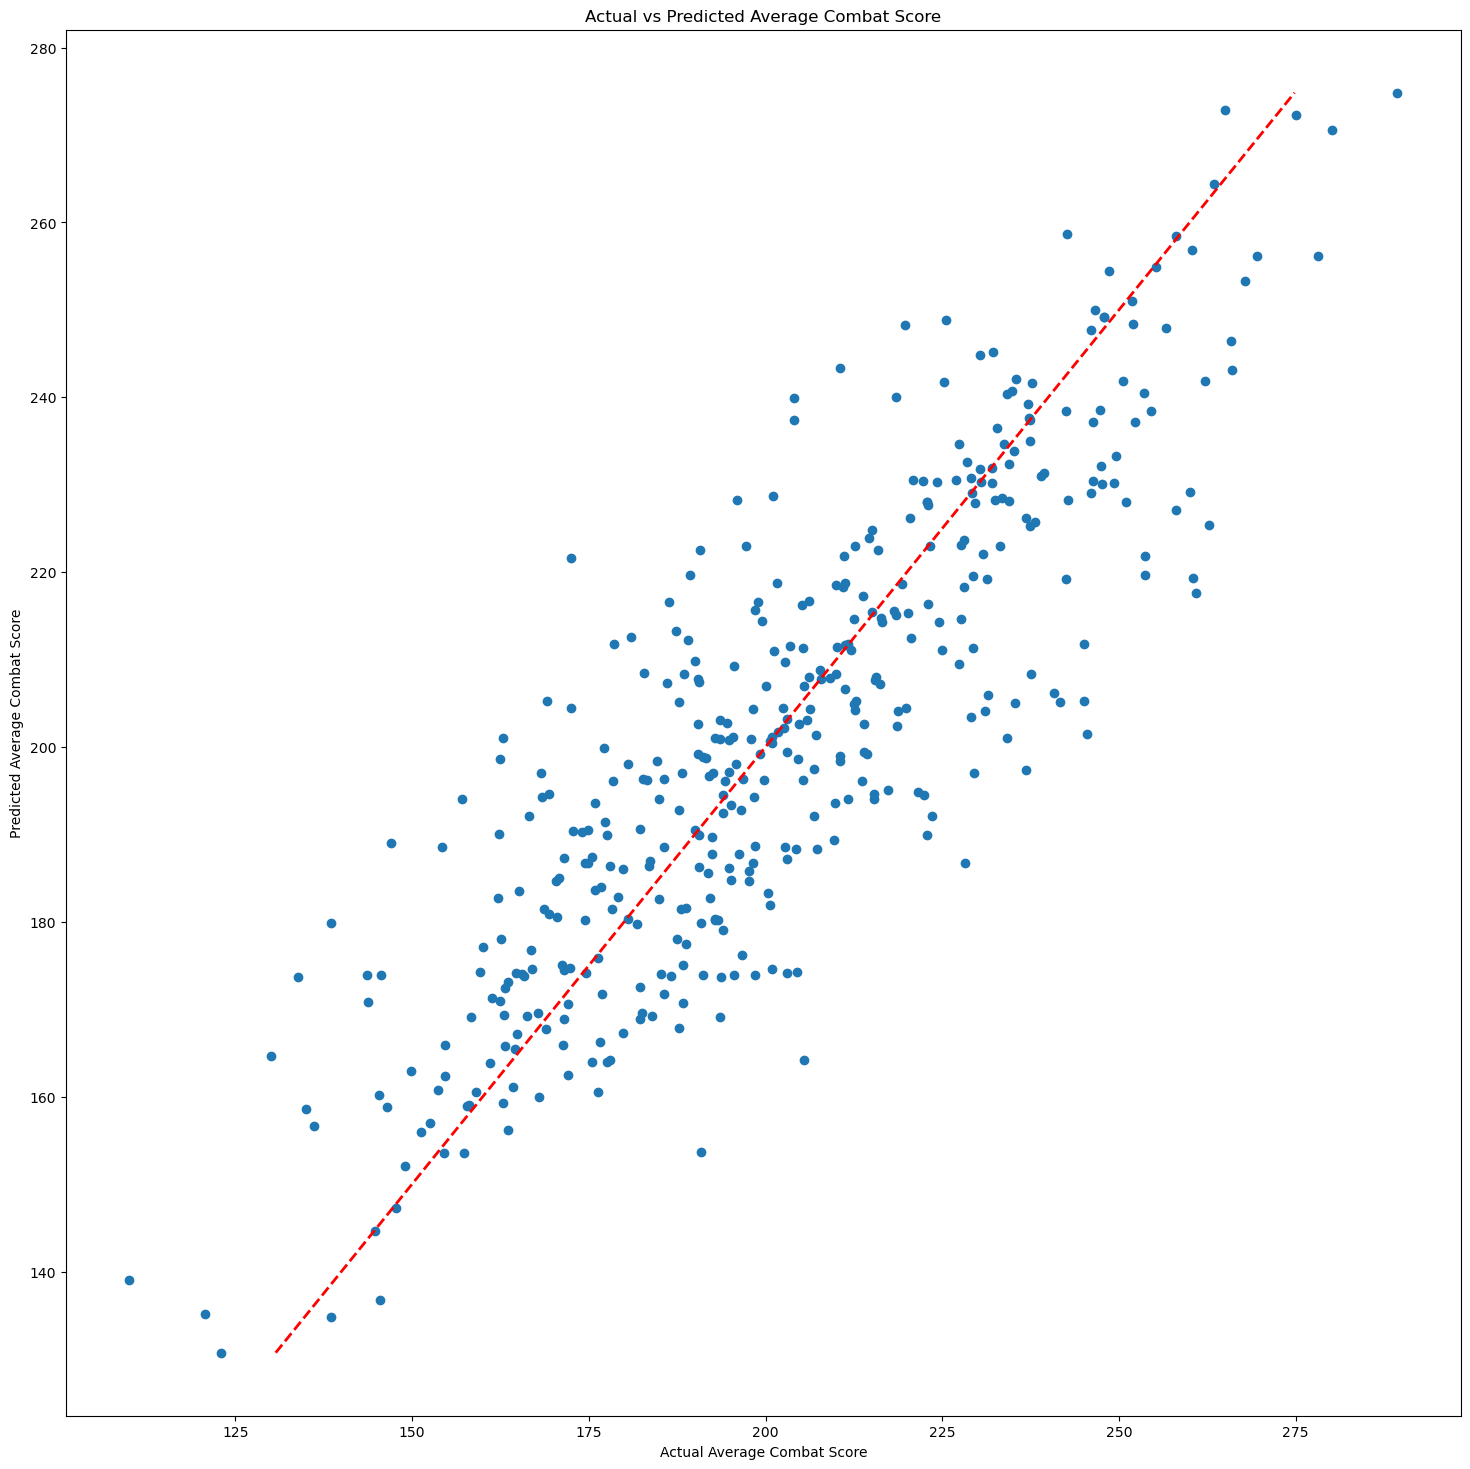

In [24]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(data['average_combat_score'], prediction_ACS)
plt.plot([min(prediction_ACS), max(prediction_ACS)], [min(prediction_ACS), max(prediction_ACS)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

In [25]:
#Predict Missing values
all_players_dates_pd = all_players_date(dates)
all_data = all_players_dates_pd.merge(data, on=['player', 'date'], how='left')
missing_data = all_data[pd.isna(all_data['average_combat_score'])].reset_index(drop=True)
missing_data_predict = playerStatPredictions(missing_data[['player', 'date']])
all_data = all_data.set_index(['player', 'date']).combine_first(missing_data_predict.set_index(['player', 'date'])).reset_index()

In [26]:
all_data

,player,date,assists_per_round,average_combat_score,average_damage_per_round,clutch_success_percentage,first_deaths_per_round,first_kills_per_round,headshot_percentage,kills_deaths,kills_per_round,months_from_Jan_2021,rating,rounds,total_assists,total_deaths,total_first_deaths,total_first_kills,total_kills
0,ANGE1,2021-05-30,0.143315,171.448959,115.634239,0.066359,0.231141,0.061739,0.355815,NaN,0.626739,NaN,NaN,NaN,192.576087,454.300000,94.600,66.869565,439.673913
1,ANGE1,2021-09-19,0.180109,170.767624,115.594565,0.071848,0.213152,0.069565,0.345109,NaN,0.619565,NaN,NaN,NaN,173.543478,454.300000,94.600,59.782609,388.956522
2,ANGE1,2021-12-12,0.207704,172.815033,115.564810,0.075965,0.199660,0.075435,0.337079,NaN,0.614185,NaN,NaN,NaN,159.269022,454.300000,94.600,54.467391,350.918478
3,ANGE1,2022-08-31,0.280000,159.600000,106.500000,0.100000,0.150000,0.080000,0.310000,0.68,0.530000,19.0,0.75,357.0,99.000000,276.000000,53.000,27.000000,189.000000
4,ANGE1,2022-10-04,0.299687,174.701401,115.465625,0.089688,0.154688,0.095000,0.310312,NaN,0.596250,NaN,NaN,NaN,111.687500,290.062500,58.875,36.750000,224.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,zekken,2022-10-04,0.228571,205.104828,137.064286,0.085000,0.137857,0.135714,0.236429,NaN,0.704286,NaN,NaN,NaN,36.714286,131.785714,24.500,24.285714,132.357143
896,zekken,2022-10-07,0.220000,241.600000,158.000000,0.070000,0.140000,0.140000,0.230000,1.11,0.820000,21.0,1.09,119.0,26.000000,87.000000,17.000,17.000000,97.000000
897,zekken,2023-02-13,0.280000,138.500000,77.300000,0.000000,0.130000,0.100000,0.240000,0.47,0.380000,25.0,0.60,39.0,10.000000,30.000000,4.000,1.000000,16.000000
898,zekken,2023-06-08,0.325714,114.561913,65.520000,0.000000,0.123571,0.067143,0.239286,NaN,0.333000,NaN,NaN,NaN,0.000000,12.600000,0.000,0.000000,6.300000


In [56]:
all_players_dates_pd = all_players_date(dates)

In [58]:
model_predict = playerStatPredictions(all_players_dates_pd)

In [27]:
#Other graphs

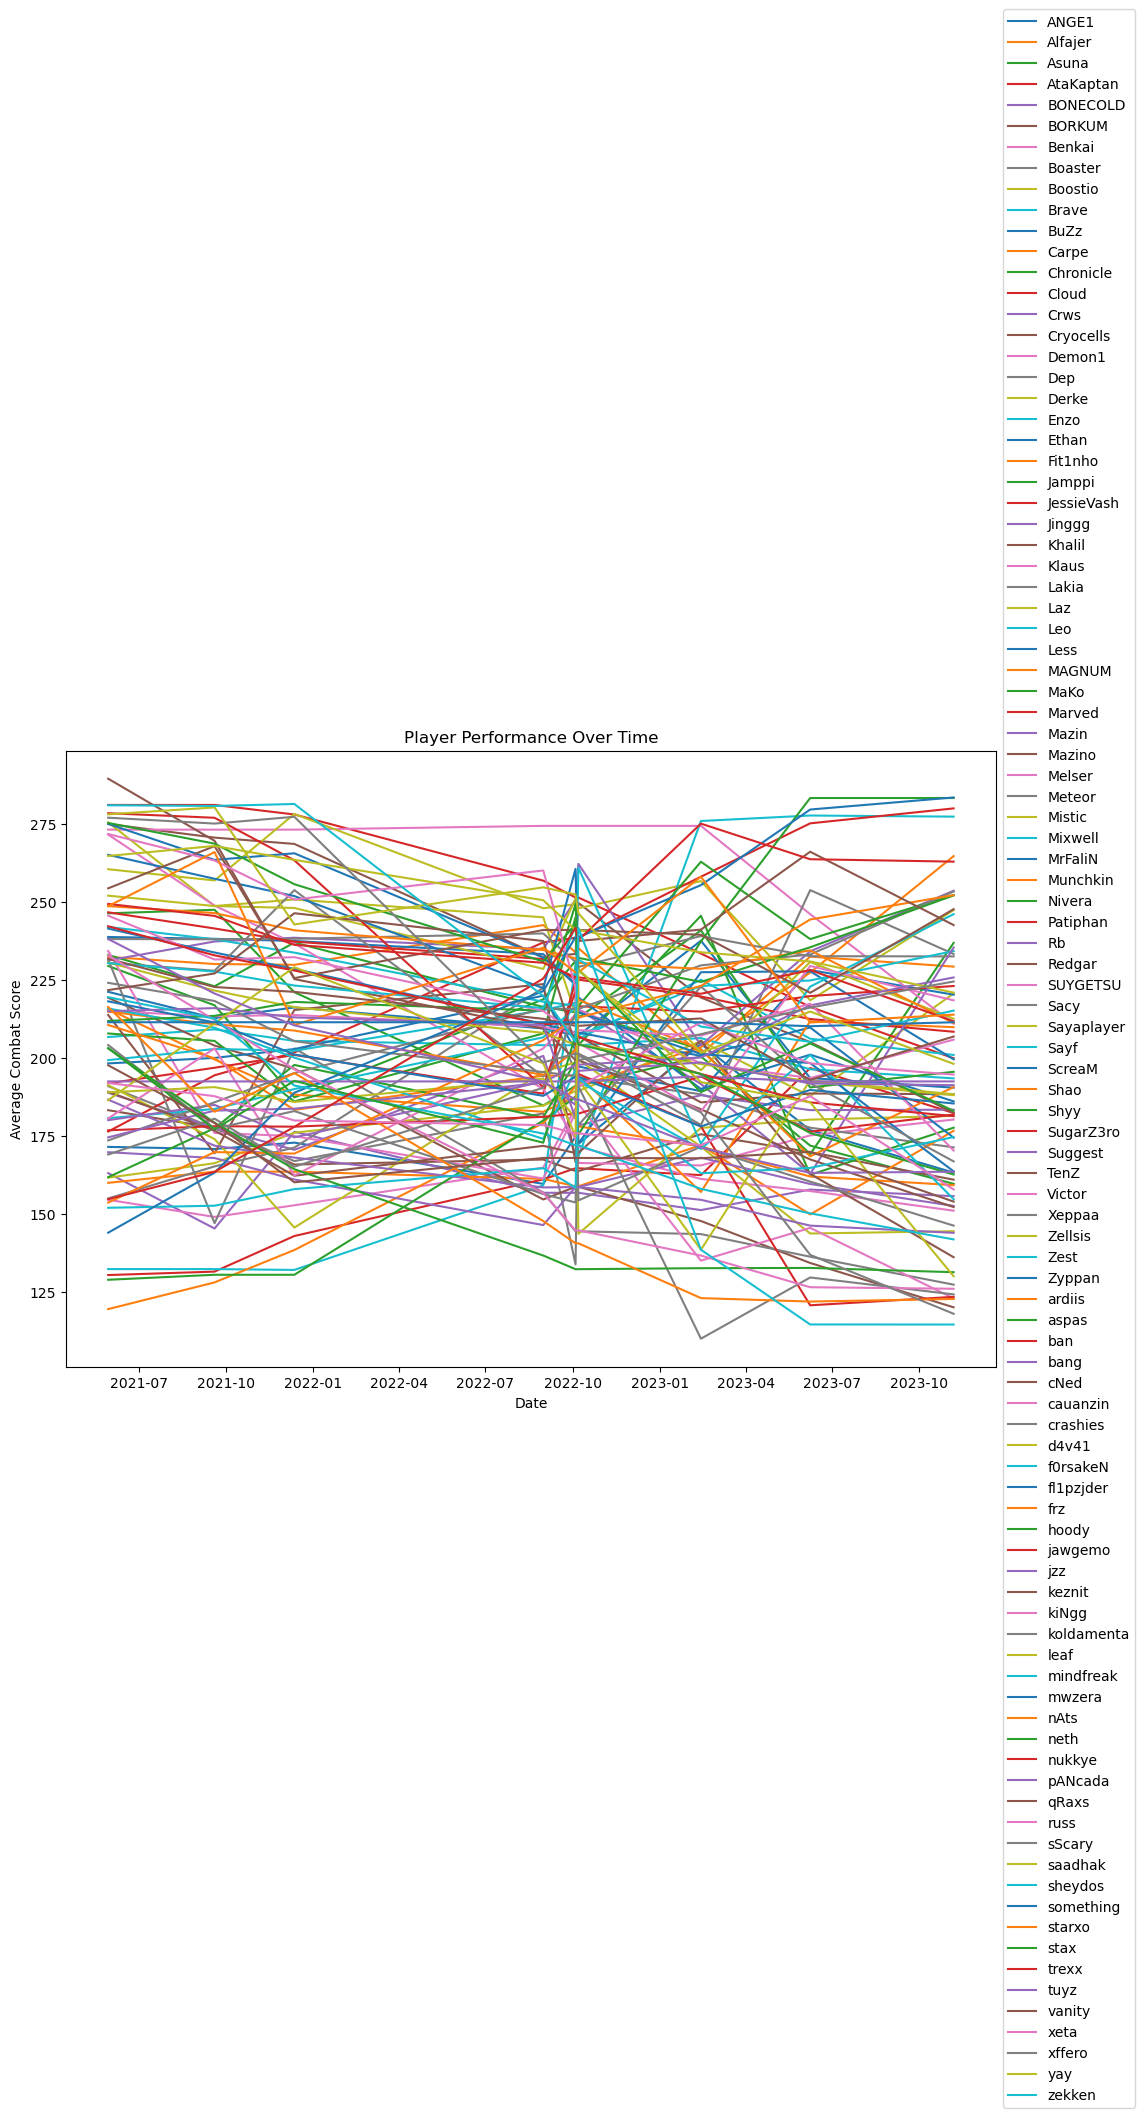

In [28]:
# Plot of all player performance over time

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in all_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [29]:
# Plot of top 5 player performance over time

In [30]:
#Get top 5 players with ACS from this period
top_ACS_players = data.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_5_ACS_players = top_ACS_players[['player', 'average_combat_score']].head(5)

In [31]:
top_5_ACS_players

,player,average_combat_score
118,TenZ,289.4
409,yay,280.2
152,Derke,278.1
207,trexx,275.0
176,cNed,267.8


In [66]:
top_5_ACS_players_data = all_data.loc[all_data['player'].isin(top_5_ACS_players['player'])]

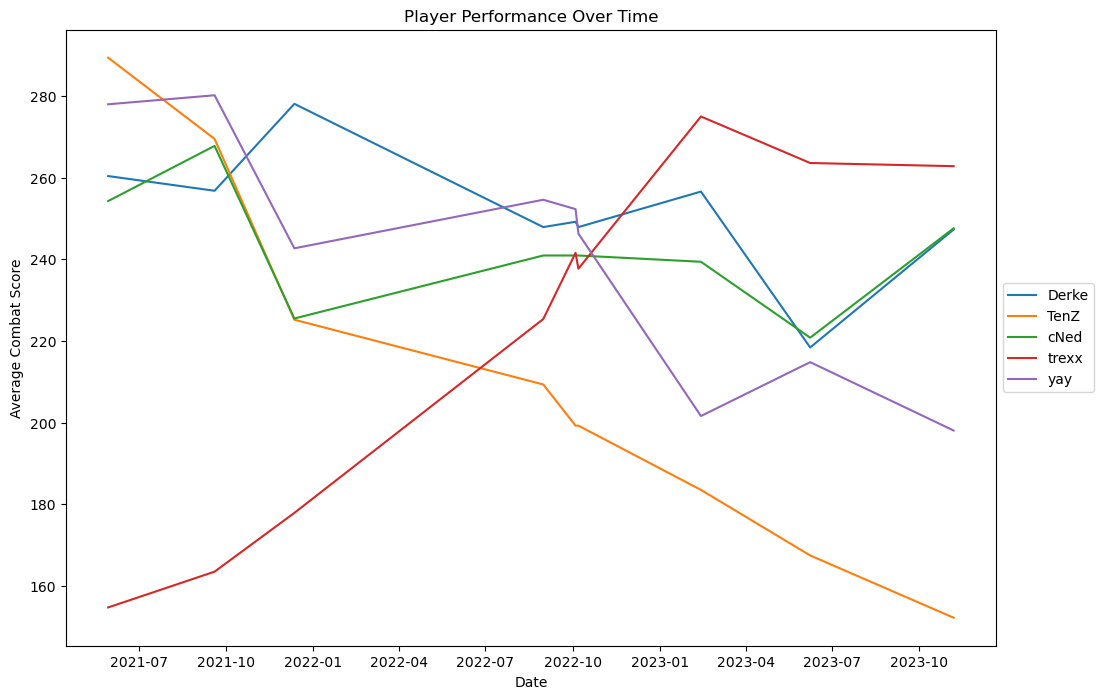

In [67]:
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_5_ACS_players_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [34]:
#Get ACS and stats of players at next tournament date
next_tourney_date = '2024/1/23'
players_tournament = pd.DataFrame({'player':players, 'date':next_tourney_date})
players_tournament['date'] = pd.to_datetime(players_tournament['date'])

In [35]:
players_tournament = playerStatPredictions(players_tournament)

In [36]:
#Top 10 players next tournament
players_tournament.sort_values('average_combat_score', ascending=False).head(10)

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,average_combat_score
8,mwzera,2024-01-23,1.122000,0.406429,199.320000,0.121429,0.070000,0.239286,0.314286,78.857143,43.785714,26.357143,8.571429e+00,3.428571,283.587738
12,Shyy,2024-01-23,1.122000,0.000000,199.320000,0.366429,0.000000,0.127143,0.038214,97.500000,12.600000,0.000000,3.992857e+01,0.000000,283.206482
93,JessieVash,2024-01-23,1.120000,0.265000,190.057143,0.117857,0.145714,0.357143,0.000000,47.428571,25.357143,0.000000,3.500000e+00,3.714286,279.133972
63,Enzo,2024-01-23,1.122000,0.000000,199.320000,0.412500,0.007500,0.305000,0.290000,6.300000,12.600000,0.000000,0.000000e+00,0.000000,277.243683
51,trexx,2024-01-23,1.122000,0.000000,199.320000,0.000000,0.035000,0.550000,0.000000,6.300000,12.600000,0.000000,0.000000e+00,0.000000,262.826416
46,Fit1nho,2024-01-23,0.932500,0.190000,183.100000,0.207500,0.167500,0.167500,0.605000,231.500000,228.500000,53.750000,5.550000e+01,41.500000,260.834930
21,frz,2024-01-23,0.932653,0.344082,174.361224,0.091224,0.000000,0.402857,0.000000,19.510204,12.600000,8.734694,3.552714e-15,0.000000,255.159760
48,Nivera,2024-01-23,0.932885,0.311346,155.380769,0.990000,0.110192,0.295385,0.055192,116.480769,100.346154,28.923077,3.761538e+01,14.750000,254.010574
4,Xeppaa,2024-01-23,1.042857,0.240714,144.621429,0.115714,0.056429,0.277143,0.693000,16.500000,12.600000,0.000000,3.571429e-01,0.000000,252.220795
14,aspas,2024-01-23,0.859039,0.178129,161.487159,0.217846,0.163377,0.280485,0.084833,214.109201,172.470172,38.532861,5.005763e+01,27.296259,251.688828


In [37]:
#Get ACS and stats of players at next tournaments
future_dates = ['2024-01-23', '2024-03-15', '2024-04-01']

In [38]:
multiple_player_tournament = playerStatPredictions(all_players_date(future_dates))

In [39]:
multiple_player_tournament

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,average_combat_score
0,Cryocells,2024-01-23,0.553571,0.480714,123.582143,0.040714,0.275000,0.099000,0.000000,6.300000,35.071429,92.178571,0.000000,29.607143,177.768265
1,Cryocells,2024-03-15,0.515000,0.525000,120.375000,0.025000,0.275000,0.099000,0.000000,6.300000,21.500000,100.250000,0.000000,30.250000,174.692291
2,Cryocells,2024-04-01,0.495714,0.547143,118.771429,0.017143,0.275000,0.099000,0.000000,6.300000,14.714286,104.285714,0.000000,30.571429,173.676956
3,bang,2024-01-23,0.795000,0.303333,144.400000,0.240000,0.175000,0.371667,0.000000,160.166667,180.500000,64.500000,42.166667,33.833333,226.099136
4,bang,2024-03-15,0.805000,0.296667,146.200000,0.260000,0.185000,0.368333,0.000000,165.833333,189.500000,65.500000,45.833333,36.166667,226.099136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,yay,2024-03-15,0.710905,0.130959,114.860015,0.125785,0.122614,0.279969,0.000000,336.524362,263.336427,49.179428,62.993813,52.005414,190.625015
296,yay,2024-04-01,0.702900,0.130681,112.839366,0.122815,0.122823,0.281268,0.000000,339.501160,266.206497,49.643465,63.253674,52.778036,184.782135
297,hoody,2024-01-23,0.551667,0.526667,120.508333,0.065833,0.148333,0.157083,0.084167,104.000000,113.666667,92.166667,13.708333,24.708333,181.030182
298,hoody,2024-03-15,0.521667,0.566667,116.358333,0.060833,0.158333,0.139583,0.069167,106.000000,117.666667,101.166667,13.958333,26.958333,169.149094


In [40]:
#Top 10 players at the next 3 tournaments
multiple_player_tournament[['player', 'date', 'average_combat_score']].sort_values('average_combat_score', ascending=False).head(10)

,player,date,average_combat_score
24,mwzera,2024-01-23,283.587738
37,Shyy,2024-03-15,283.206482
36,Shyy,2024-01-23,283.206482
38,Shyy,2024-04-01,283.206482
26,mwzera,2024-04-01,283.150208
25,mwzera,2024-03-15,283.150208
279,JessieVash,2024-01-23,279.133972
190,Enzo,2024-03-15,278.736755
191,Enzo,2024-04-01,278.736755
189,Enzo,2024-01-23,277.243683


In [41]:
#Get top 5 players with ACS from this period
top_ACS_players_next = multiple_player_tournament.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_5_ACS_players_next = top_ACS_players_next[['player', 'average_combat_score']].head(5)

In [42]:
top_5_ACS_players_next

,player,average_combat_score
24,mwzera,283.587738
37,Shyy,283.206482
279,JessieVash,279.133972
190,Enzo,278.736755
140,Fit1nho,276.781555


In [43]:
top_5_ACS_players_next_data = multiple_player_tournament.loc[multiple_player_tournament['player'].isin(top_5_ACS_players['player'])]

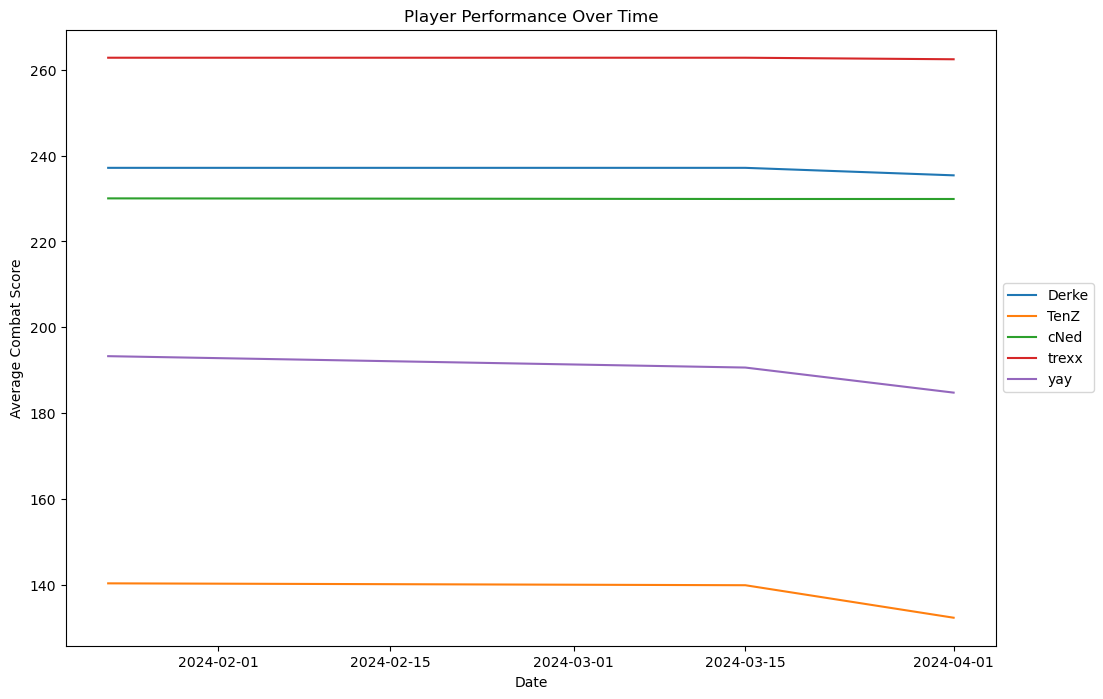

In [44]:
#Plot performance
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_5_ACS_players_next_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [45]:
#Join two models
all_data_extend = pd.concat([all_data, multiple_player_tournament])

In [46]:
all_data_extend

,player,date,assists_per_round,average_combat_score,average_damage_per_round,clutch_success_percentage,first_deaths_per_round,first_kills_per_round,headshot_percentage,kills_deaths,kills_per_round,months_from_Jan_2021,rating,rounds,total_assists,total_deaths,total_first_deaths,total_first_kills,total_kills
0,ANGE1,2021-05-30,0.143315,171.448959,115.634239,0.066359,0.231141,0.061739,0.355815,NaN,0.626739,NaN,NaN,NaN,192.576087,454.300000,94.600000,66.869565,439.673913
1,ANGE1,2021-09-19,0.180109,170.767624,115.594565,0.071848,0.213152,0.069565,0.345109,NaN,0.619565,NaN,NaN,NaN,173.543478,454.300000,94.600000,59.782609,388.956522
2,ANGE1,2021-12-12,0.207704,172.815033,115.564810,0.075965,0.199660,0.075435,0.337079,NaN,0.614185,NaN,NaN,NaN,159.269022,454.300000,94.600000,54.467391,350.918478
3,ANGE1,2022-08-31,0.280000,159.600000,106.500000,0.100000,0.150000,0.080000,0.310000,0.68,0.530000,19.0,0.75,357.0,99.000000,276.000000,53.000000,27.000000,189.000000
4,ANGE1,2022-10-04,0.299687,174.701401,115.465625,0.089688,0.154688,0.095000,0.310312,NaN,0.596250,NaN,NaN,NaN,111.687500,290.062500,58.875000,36.750000,224.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,yay,2024-03-15,0.130959,190.625015,114.860015,0.000000,0.122614,0.125785,0.279969,NaN,0.710905,NaN,NaN,NaN,49.179428,263.336427,52.005414,62.993813,336.524362
296,yay,2024-04-01,0.130681,184.782135,112.839366,0.000000,0.122823,0.122815,0.281268,NaN,0.702900,NaN,NaN,NaN,49.643465,266.206497,52.778036,63.253674,339.501160
297,hoody,2024-01-23,0.526667,181.030182,120.508333,0.084167,0.148333,0.065833,0.157083,NaN,0.551667,NaN,NaN,NaN,92.166667,113.666667,24.708333,13.708333,104.000000
298,hoody,2024-03-15,0.566667,169.149094,116.358333,0.069167,0.158333,0.060833,0.139583,NaN,0.521667,NaN,NaN,NaN,101.166667,117.666667,26.958333,13.958333,106.000000


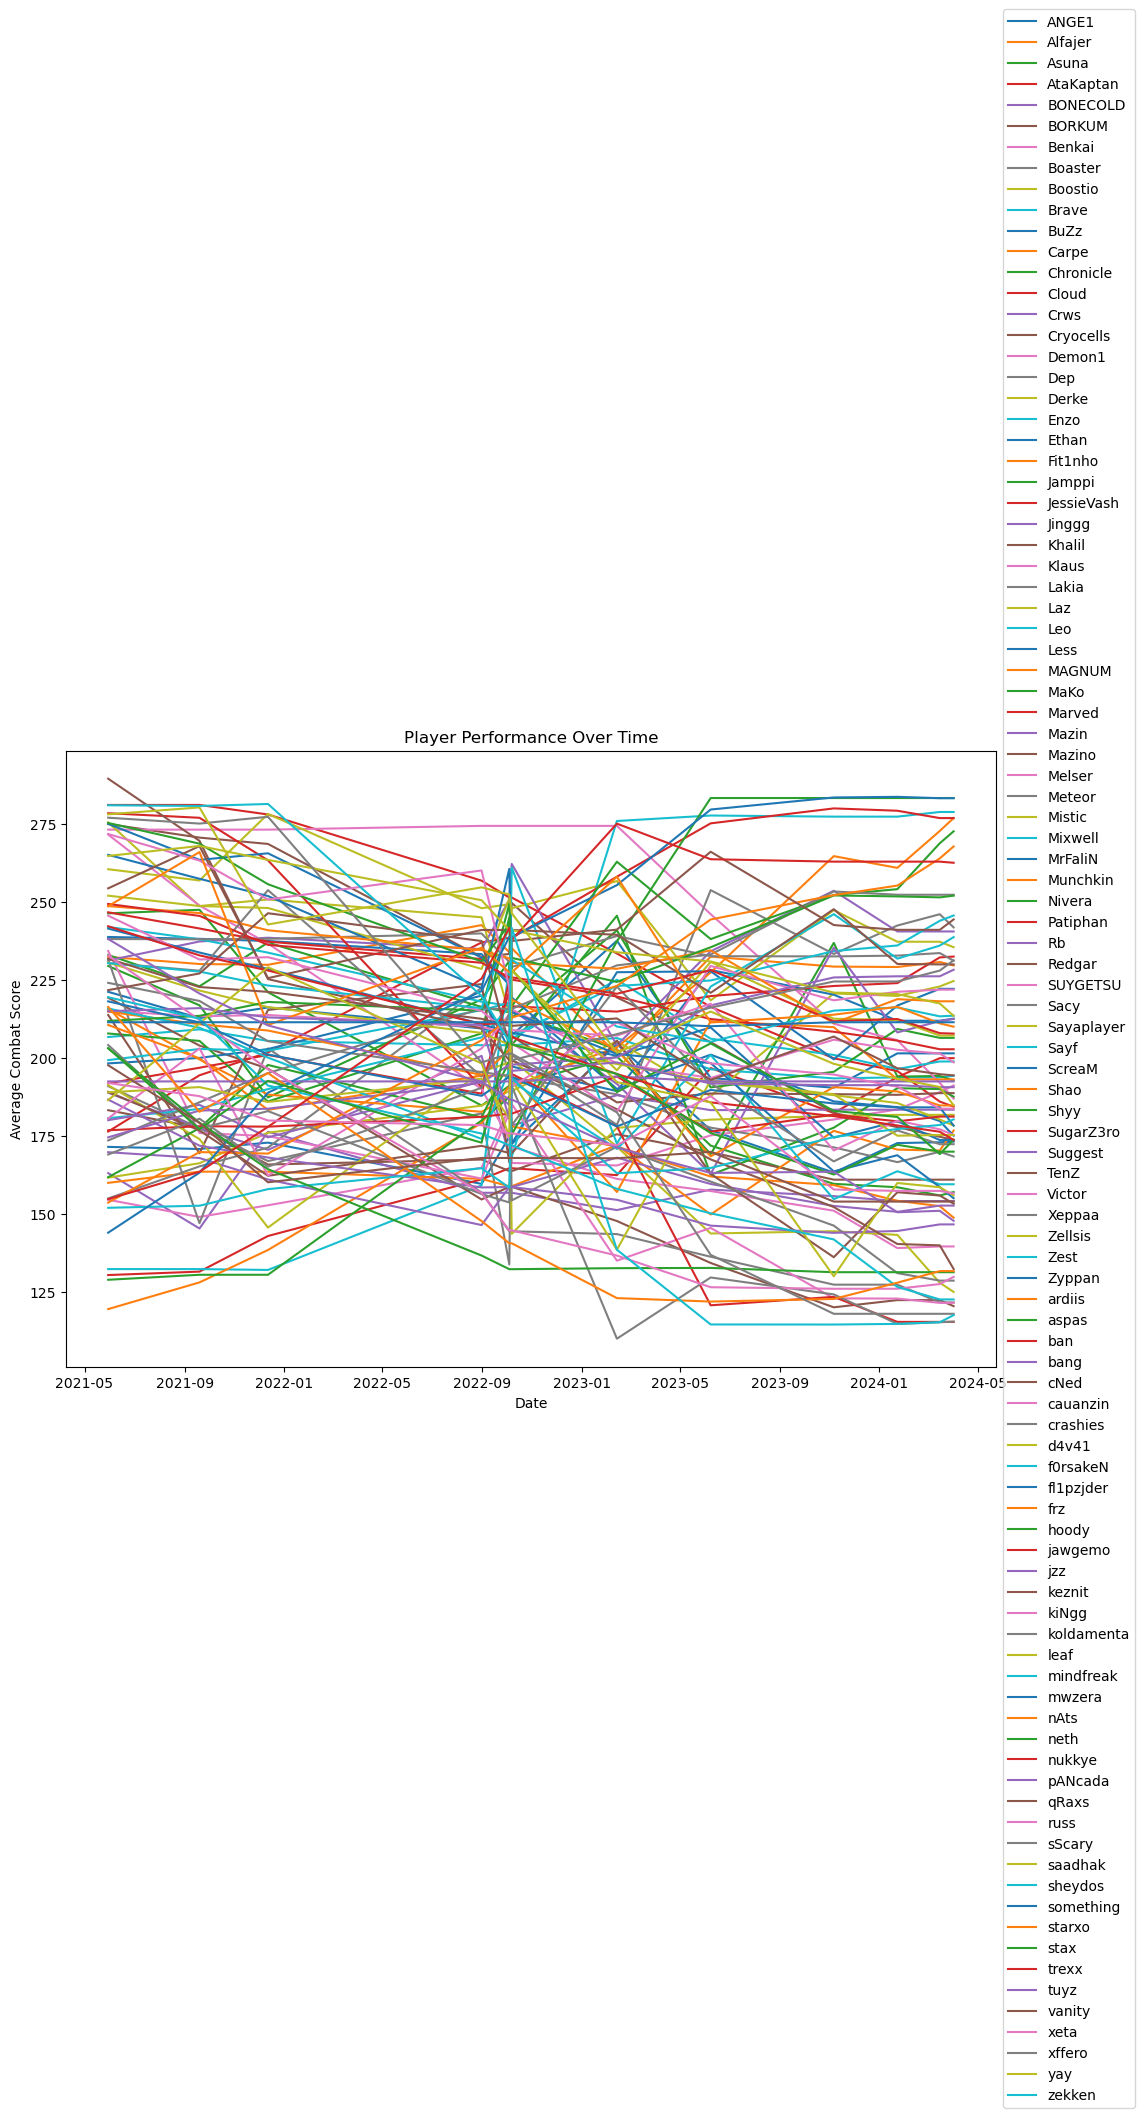

In [47]:
# Plot of all player performance over time

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in all_data_extend.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [48]:
#Get top 10 players with ACS from this period
top_ACS_players_all = all_data_extend.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_10_ACS_players_all = top_ACS_players_all[['player', 'average_combat_score']].head(10)

In [49]:
top_10_ACS_players_all

,player,average_combat_score
495,TenZ,289.400000
24,mwzera,283.587738
37,Shyy,283.206482
893,zekken,281.298157
118,Cloud,280.990784
883,yay,280.200000
215,JessieVash,279.883728
191,Enzo,278.736755
477,SugarZ3ro,278.342773
164,Derke,278.100000


In [50]:
top_10_ACS_players_data_all = all_data_extend.loc[all_data_extend['player'].isin(top_10_ACS_players_all['player'])]

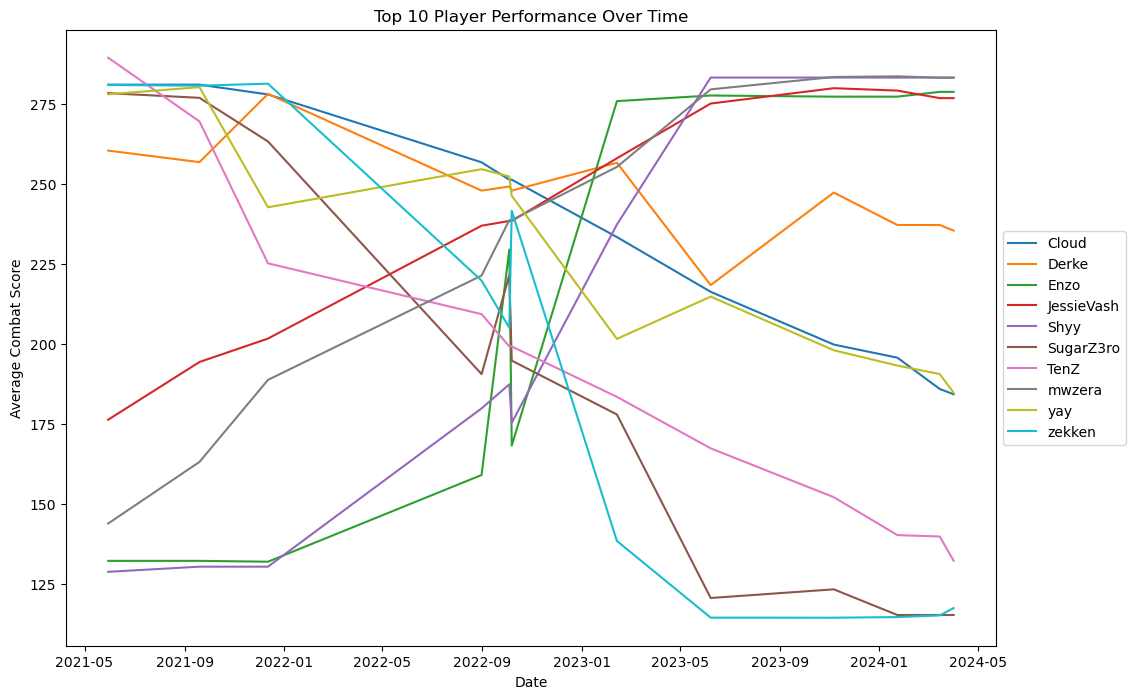

In [51]:
#Plot performance
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_10_ACS_players_data_all.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Top 10 Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [52]:
#Get top 10 players with ACS at final date
top_ACS_players_all = all_data_extend.loc[all_data_extend['date'] == '2024-04-01'].sort_values('average_combat_score', ascending=False)
top_10_ACS_players_all = top_ACS_players_all[['player', 'average_combat_score']].head(10)

In [53]:
top_10_ACS_players_all

,player,average_combat_score
38,Shyy,283.206482
26,mwzera,283.150208
191,Enzo,278.736755
140,Fit1nho,276.781555
281,JessieVash,276.780670
146,Nivera,272.544220
65,frz,267.693665
155,trexx,262.466553
14,Xeppaa,252.220795
44,aspas,251.921616


In [54]:
top_10_ACS_players_all

,player,average_combat_score
38,Shyy,283.206482
26,mwzera,283.150208
191,Enzo,278.736755
140,Fit1nho,276.781555
281,JessieVash,276.780670
146,Nivera,272.544220
65,frz,267.693665
155,trexx,262.466553
14,Xeppaa,252.220795
44,aspas,251.921616


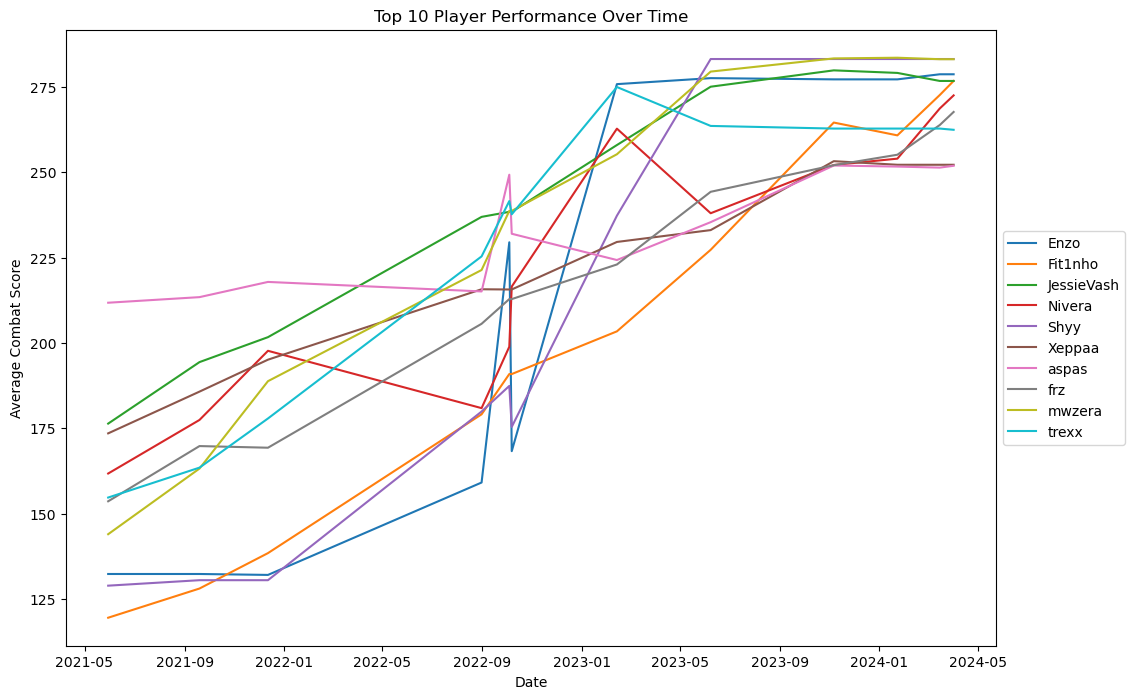

In [55]:
#Plot performance
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

top_10_ACS_players_data_all = all_data_extend.loc[all_data_extend['player'].isin(top_10_ACS_players_all['player'])]

# Plotting the performance of players from every tournament
for player_name, player_data in top_10_ACS_players_data_all.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Top 10 Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [35]:
feature_models = player_feature_models_beta
predict_player_feature('TenZ', pd.to_datetime(dates[1]), 'kills_per_round')

0.73634

In [13]:
date_ex = months_from_2021(pd.to_datetime(dates))

In [27]:
np.array(date_ex)

array([21, 19, 25,  8, 34, 29, 11,  4, 21])

In [ ]:
feature_models = player_feature_models_linear
feature_models.get('TenZ').get('kills_per_round')

In [ ]:
data['months_from_Jan_2021'].values[:,np.newaxis]

In [16]:
prediction_data_all = feature_models.get('TenZ').get('kills_per_round').predict(np.array(date_ex)[:,np.newaxis])

In [17]:
prediction_data_all

array([0.70458, 0.73634, 0.64106, 0.91102, 0.49814, 0.57754, 0.86338,
       0.97454, 0.70458])

In [18]:
feature_models = player_feature_models_beta
feature_models.get('TenZ').get('kills_per_round')

In [ ]:
np.array([np.array(date_ex)[0]])

In [ ]:
prediction_data_all = feature_models.get('TenZ').get('kills_per_round').predict(np.array(date_ex))

In [ ]:
prediction_data_all = feature_models.get('TenZ').get('kills_per_round').predict(np.array([np.array(date_ex)[0]]))

In [ ]:
prediction_data_all

In [22]:
pd.to_datetime(dates[0])

Timestamp('2022-10-07 00:00:00')

In [23]:
feature_models = player_feature_models_linear
predict_player_feature('TenZ', pd.to_datetime(dates[0]), 'kills_per_round')

0.70458